In [27]:
from mypulp import *
import numpy as np
import itertools
import networkx as nx
import math
import matplotlib.pyplot as plt
%matplotlib inline

# グラフ分割問題

In [2]:
def make_example(n, prob):
    np.random.seed(7)
    V = range(n)
    E = [(i, j) for i in V for j in V if i<j and np.random.rand()<prob]
    return n, V, E

In [3]:
def solve_gpp(V, E):
    model = Model('gpp')
    
    ## 変数 ##
    x, y = {}, {}
    for i in V:
        x[i] = model.addVar(vtype='B', name=f'x_{i}')
    for i, j in E:
        y[i, j] = model.addVar(vtype='B', name=f'y_{i},{j}')
    model.update()
    
    ## 定式化 ##
    model.addConstr(quicksum(x[i] for i in V) == n/2)
    
    for i, j in E:
        model.addConstr(x[i] - x[j] <= y[i, j])
        model.addConstr(x[j] - x[i] <= y[i, j])

    model.setObjective(quicksum(y[i, j] for i, j in E), GRB.MINIMIZE)
    
    model.update()
    model.__data = x
    
    return model        

In [4]:
n, V, E = make_example(20, 0.3)
model = solve_gpp(V, E)
model.optimize()
x = model.__data

# 最適解
print(f'Optimal Value: {model.ObjVal}')

eps = 1.0e-6
optsol = []
for i in x:
    if x[i].X > eps:
        optsol.append(x[i])
print(f'Optimal Solution: {optsol}')

Optimal Value: 17.0
Optimal Solution: [x_0, x_1, x_2, x_3, x_5, x_6, x_8, x_14, x_15, x_19]


# 最大安定集合問題

In [5]:
def solve_ssp(V, E):
    model = Model('ssp')

    ## 変数 ##
    x = {}
    for i in V:
        x[i] = model.addVar(vtype='B', name=f'x_{i}')
    model.update()
    
    ## 定式化 ##    
    for i, j in E:
        model.addConstr(x[i] + x[j] <= 1)

    model.setObjective(quicksum(x[i] for i in V), GRB.MAXIMIZE)
    
    model.update()
    model.__data = x
    
    return model

In [6]:
n, V, E = make_example(15, 0.3)
model = solve_ssp(V, E)
model.optimize()
x = model.__data

# 最適解
print(f'Optimal Value: {model.ObjVal}')

eps = 1.0e-6
optsol = []
optidx = []
for i in x:
    if x[i].X > eps:
        optsol.append(x[i])
        optidx.append(i)
print(f'Optimal Solution: {optsol}')

Optimal Value: 7.0
Optimal Solution: [x_0, x_3, x_5, x_6, x_7, x_10, x_12]


C:\Users\kengo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


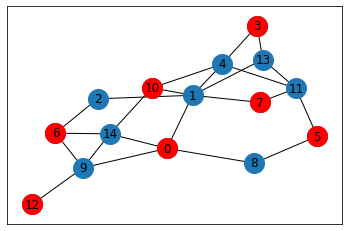

In [7]:
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)
p = nx.spring_layout(G, iterations=100)
nx.draw_networkx(G, pos=p, node_size=400)
nx.draw_networkx_nodes(G, pos=p, node_size=400, node_color='red', nodelist=optidx)

# グラフ彩色問題

In [8]:
def solve_gcp(V, E, K):
    model = Model('gcp')

    ## 変数 ##
    x, y = {}, {}
    for k in K:
        y[k] = model.addVar(vtype='B', name=f'y_{k}')
        for i in V:
            x[i, k] = model.addVar(vtype='B', name=f'x_{i},{k}')
    model.update()
    
    ## 定式化 ##
    for i in V:
        model.addConstr(quicksum(x[i, k] for k in K) == 1)
    for i, j in E:
        for k in K:
            model.addConstr(x[i, k] + x[j, k] <= y[k])
    for k in range(n-1):
        model.addConstr(y[k] >= y[k+1])
    
    model.setObjective(quicksum(y[k] for k in K), GRB.MINIMIZE)
    
    model.update()
    model.__data = x
    
    return model

In [9]:
n, V, E = make_example(15, 0.3)
K = range(n)
model = solve_gcp(V, E, K)
model.optimize()
x = model.__data

# 最適解
print(f'Optimal Value: {model.ObjVal}')

eps = 1.0e-6
optsol = []
for i, k in x:
    if x[i, k].X > eps:
        optsol.append(x[i, k])

print(f'Optimal Solution: {optsol}')

Optimal Value: 3.0
Optimal Solution: [x_0,0, x_3,0, x_6,0, x_7,0, x_10,0, x_2,1, x_4,1, x_5,1, x_9,1, x_13,1, x_1,2, x_8,2, x_11,2, x_12,2, x_14,2]


色数を固定して二分探索により求める

In [10]:
def solve_gcp_fixed(V, E, K):
    model = Model('gcp_fixed')

    ## 変数 ##
    x, z = {}, {}
    for k in K:
        for i in V:
            x[i, k] = model.addVar(vtype='B', name=f'x_{i},{k}')
    for i, j in E:
        z[i, j] = model.addVar(vtype='B', name=f'z_{i},{j}')            
    model.update()
    
    ## 定式化 ##
    for i in V:
        model.addConstr(quicksum(x[i, k] for k in K) == 1)
    for i, j in E:
        for k in K:
            model.addConstr(x[i, k] + x[j, k] <= 1 + z[i, j])
    
    model.setObjective(quicksum(z[i, j] for i, j in E), GRB.MINIMIZE)
    
    model.update()
    model.__data = x, z
    
    return model

In [32]:
def solve_gcp2(V, E):
    # 初期値
    UB = len(V)
    LB = 1
    
    while UB - LB > 1:
        K = math.floor((UB + LB) / 2)
        
        model = solve_gcp_fixed(V, E, range(K))
        model.optimize()
        
        if model.ObjVal == 0:
            UB = K
        else:
            LB = K
    model.__data = x
    
    return model, K

In [35]:
n, V, E = make_example(15, 0.3)

model, K = solve_gcp2(V, E)
x = model.__data

# 最適解
print(f'Optimal Value: {K}')

eps = 1.0e-6
optsol = []
for i, k in x:
    if x[i, k].X > eps:
        optsol.append(x[i, k])

print(f'Optimal Solution: {optsol}')

Optimal Value: 3
Optimal Solution: [x_0,0, x_3,0, x_6,0, x_7,0, x_10,0, x_2,1, x_4,1, x_5,1, x_9,1, x_13,1, x_1,2, x_8,2, x_11,2, x_12,2, x_14,2]
